In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import os

In [2]:
# masks_path = '../locating-objects-without-bboxes/data/512_512/masks/train/'
# masks_path = '../locating-objects-without-bboxes/data/512_512/masks/test/'
masks_path = '../locating-objects-without-bboxes/data/512_512/masks/val/'

In [3]:
# write_path = '../locating-objects-without-bboxes/data/512_512/prob_masks/train/'
# write_path = '../locating-objects-without-bboxes/data/512_512/prob_masks/test/'
# write_path = '../locating-objects-without-bboxes/data/512_512/prob_masks/val/'

In [4]:
masks = os.listdir(masks_path)
masks = [mask for mask in masks if mask.endswith(".png")]
print(len(masks))
print(masks)

15
['20_lewisseth_mask.png', '17_runjalasunithaglory_mask.png', '20_chaudharyamitlakshmikant_mask.png', '19_sahapratim_mask.png', '21_cheniminenihemanthi_mask.png', '17_lakkireddybrunda_mask.png', '18_sahapratim_mask.png', '18_bungmahesh_mask.png', '18_runjalasunithaglory_mask.png', '19_bungmahesh_mask.png', '1_adhikarisaugat_mask.png', '1_ahsanmuhammad_mask.png', '20_seelamsumanthkumarreddy_mask.png', '1_pandirinikhilkumar_mask.png', '21_chaudharyamitlakshmikant_mask.png']


In [5]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

In [6]:
def gaussian_radius(det_size, min_overlap=0.7):
    
    height, width = det_size
    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2
    
    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2
    
    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    
    return min(r1, r2, r3)

In [7]:
def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
    
    x, y = int(center[0]), int(center[1])
    
    height, width = heatmap.shape[0:2]
    
    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    
    return heatmap

In [8]:
def make_gaussian_spread(image_thresh):
    """
    Input: must be a binary mask [0, 255]
    """
    ## List to save all gaussian CCs
    gauss_cc_list = list()
    
    ## Get CCs
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(image_thresh)
    
    ## Loop through each CC
    for i in range(1, numLabels):
        
        # Extract CC
        cc = np.zeros_like(labels)
        cc = np.where(labels == i, 255, 0).astype('uint8')
        
        ## CC stats has x, y, w, h and area of each CC
        x = stats[i][0]
        y = stats[i][1]
        w = stats[i][2]
        h = stats[i][3]

        # Get center of CC and convert to int
        ct = centroids[i]
        ct = np.array( [int(ct[0]), int(ct[1])] )
                
        empty_heat_map = np.zeros_like(cc).astype("float64")
        radius = gaussian_radius((math.ceil(h), math.ceil(w)), min_overlap = 0.7)
        radius = max(0, int(radius))
#         radius = math.ceil(radius*3.5)
        heat_map = draw_umich_gaussian(empty_heat_map, ct, radius )
        
        # Masked heatmap
        mask = np.zeros_like(cc).astype("float64")
        mask = np.where(cc>0, 1.0, 0.0)
        masked_heat_map = mask*heat_map
        
#         plt.figure(figsize=(15,15))
#         plt.title("Gaussian Heatmap of CC")
#         plt.imshow(masked_heat_map, cmap = 'jet')
        
        gauss_cc_list.append(masked_heat_map)
        
        
    gt_map = np.array(gauss_cc_list)
    gt_map = np.sum(gt_map, axis = 0)
    
    assert np.max(gt_map) <= 1.0, "Probabilty must not exceed 1.0"
    assert np.min(gt_map) >= 0.0, "Probabilty must not exceed 1.0"
    
    return gt_map

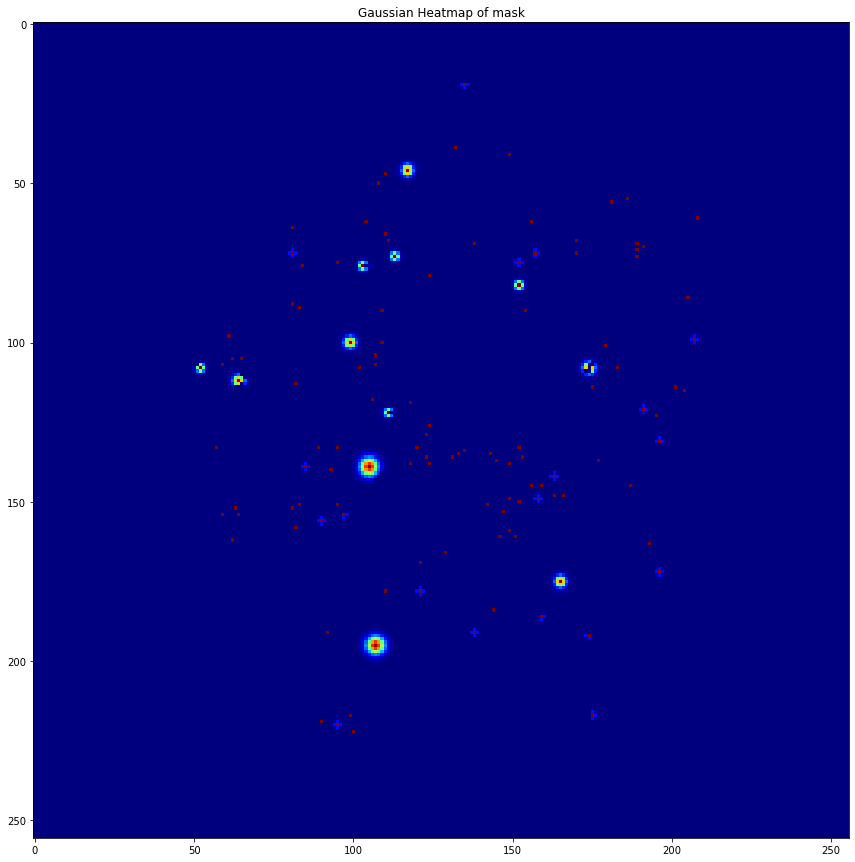

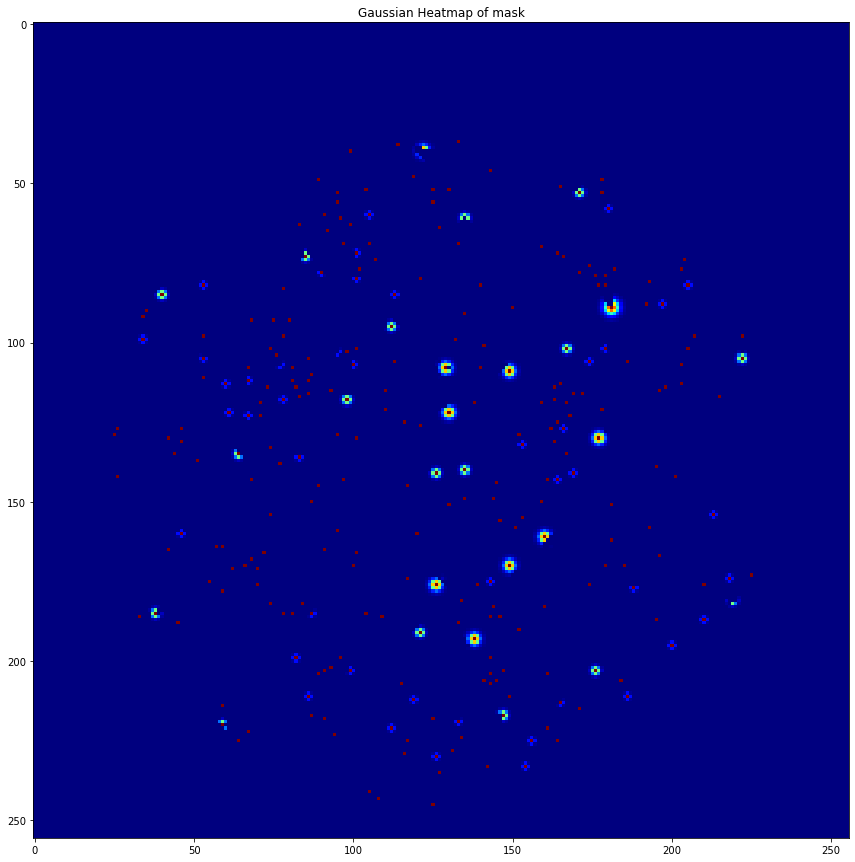

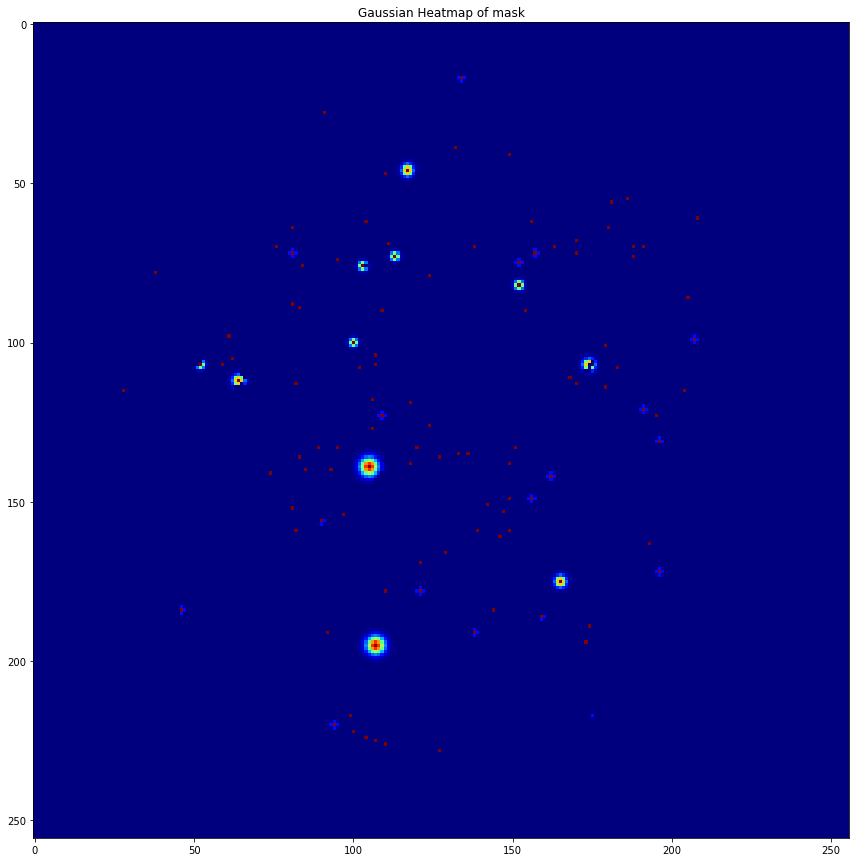

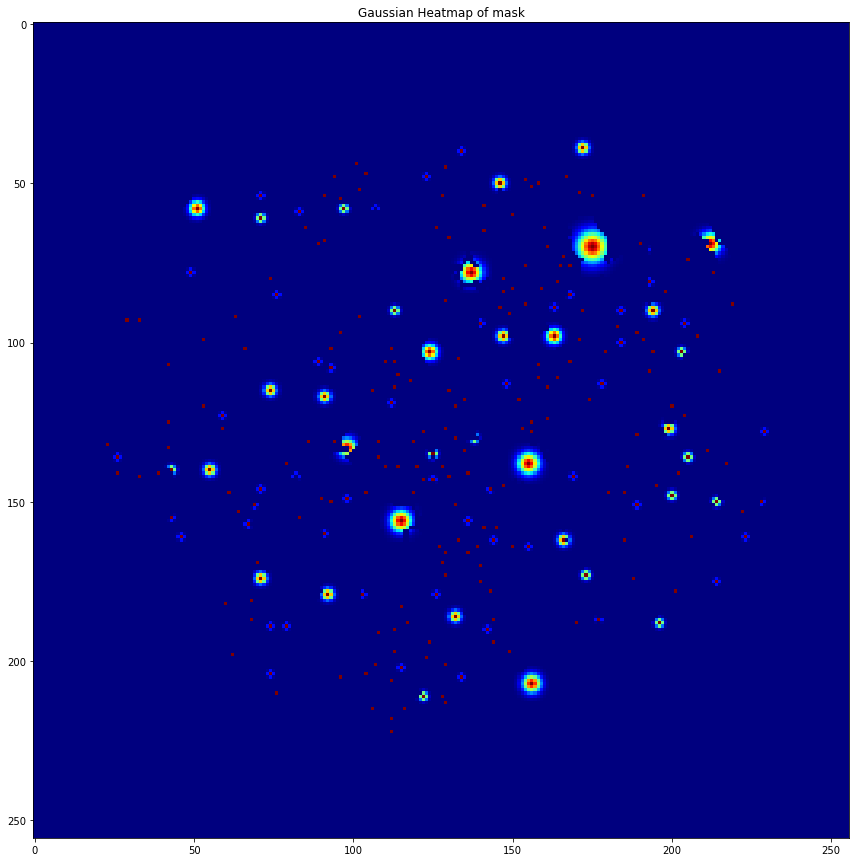

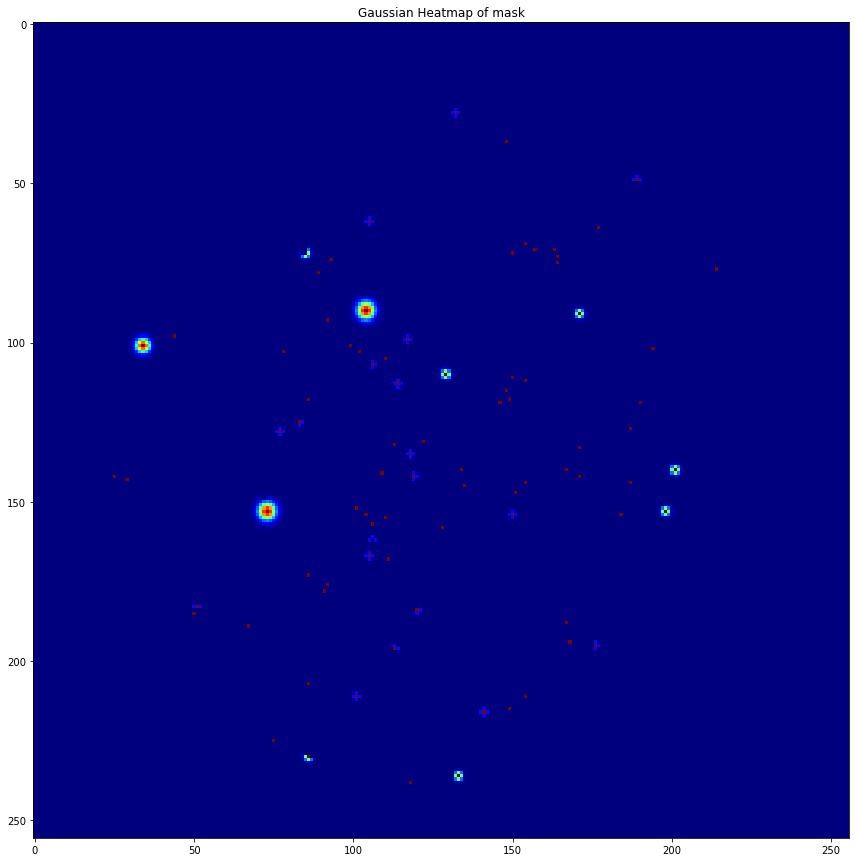

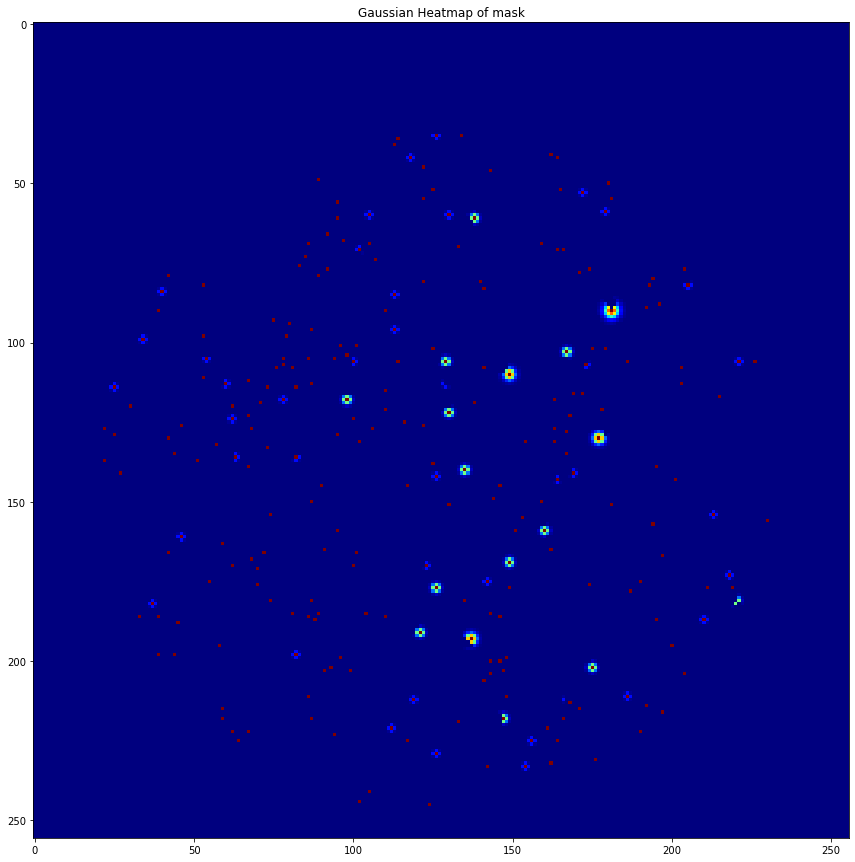

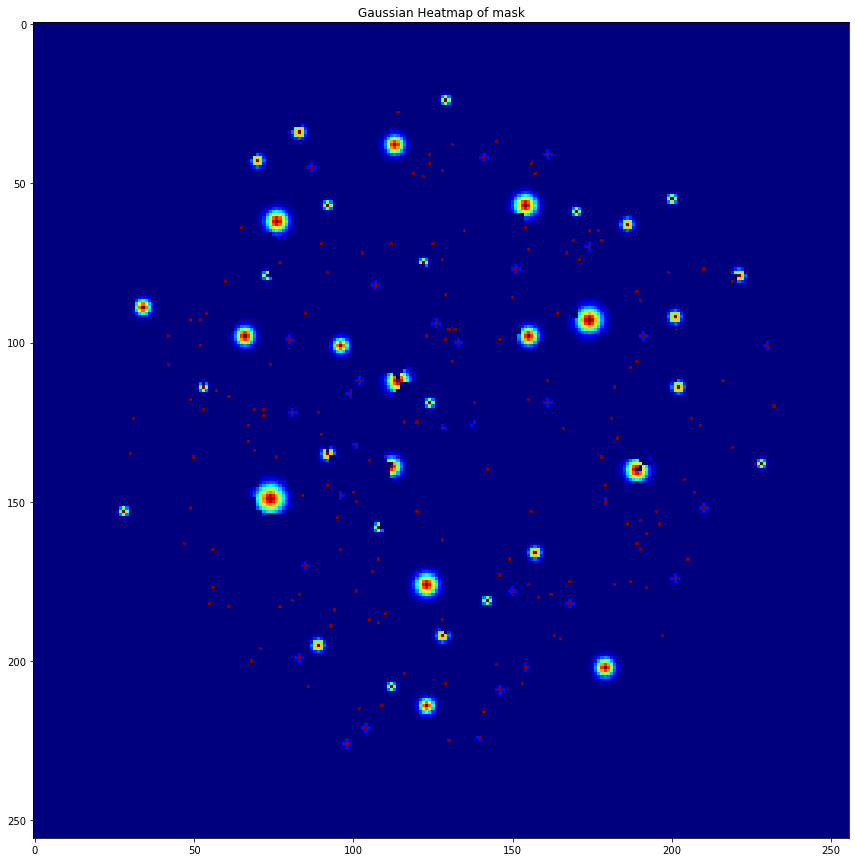

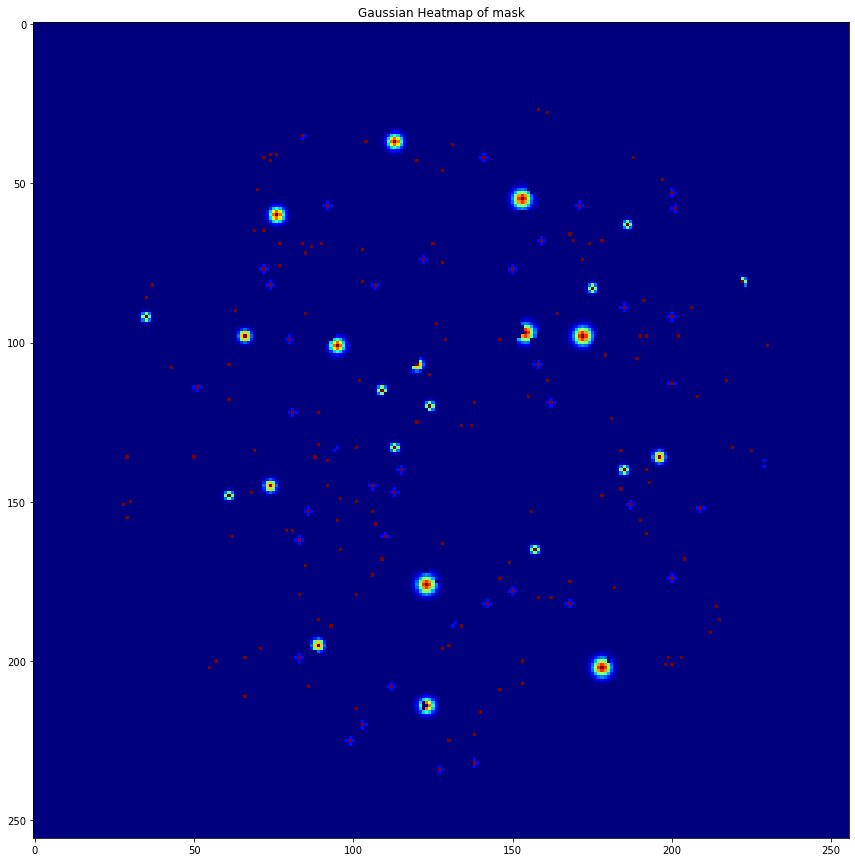

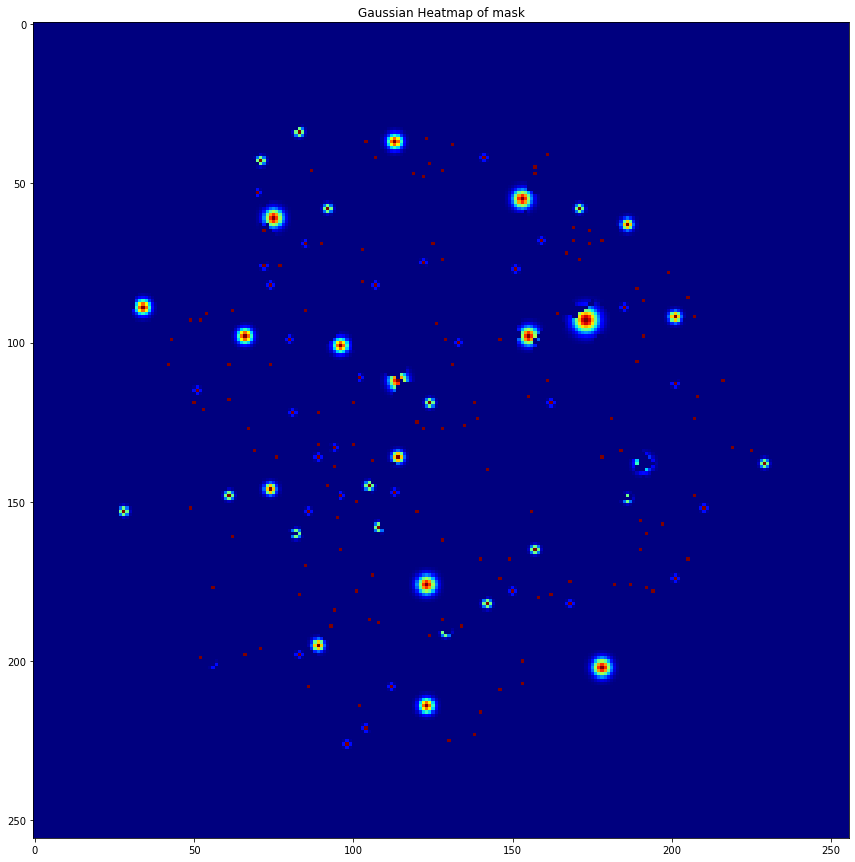

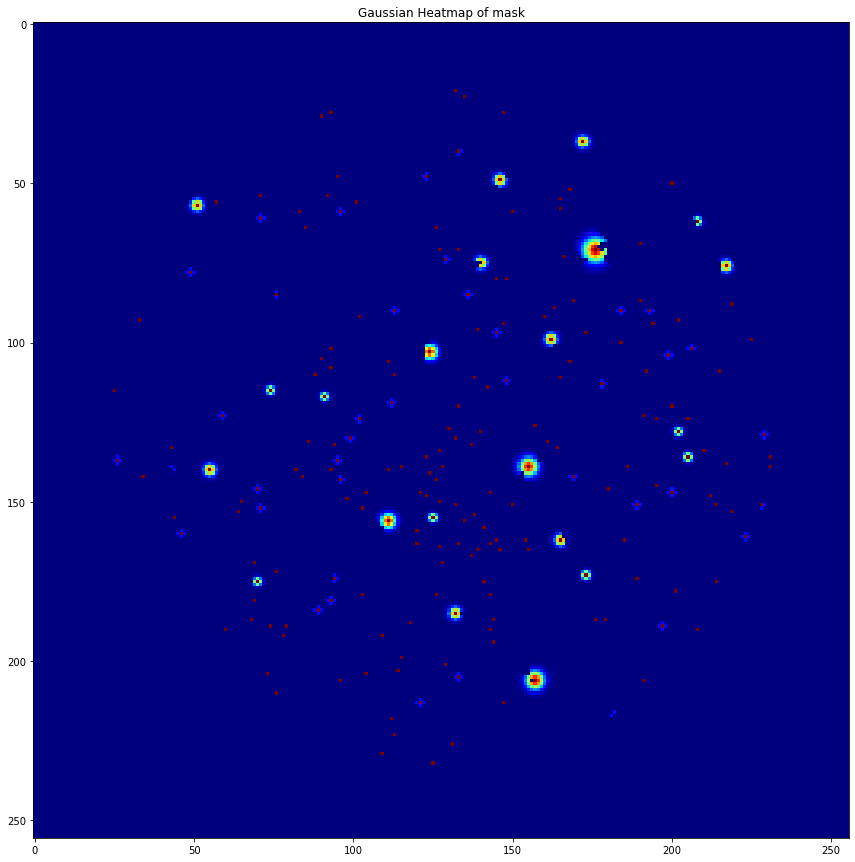

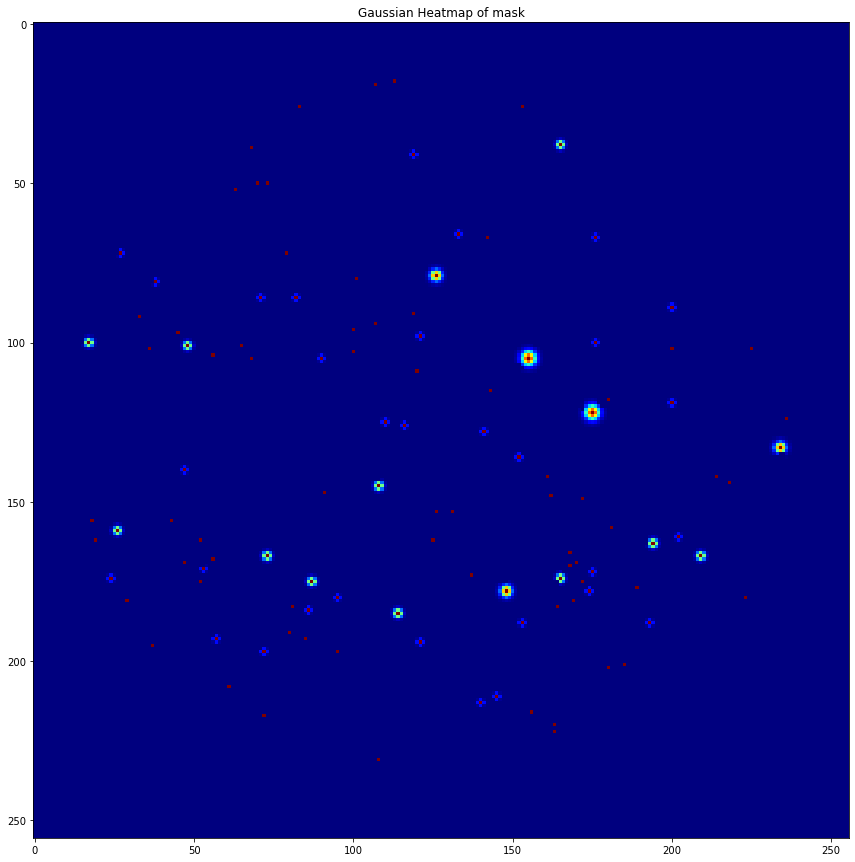

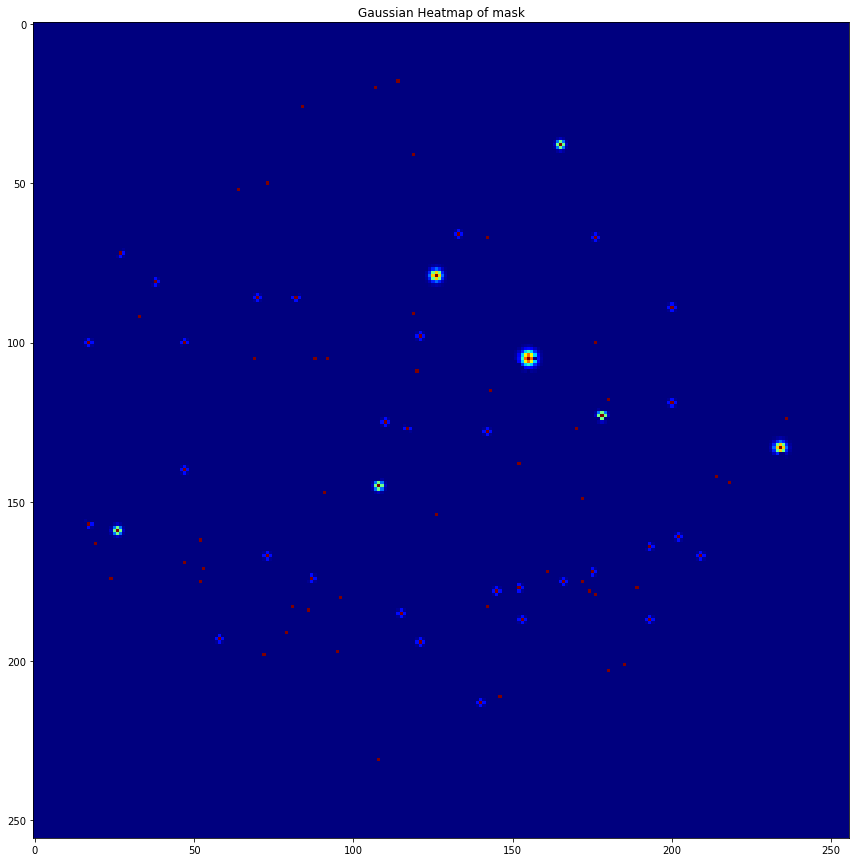

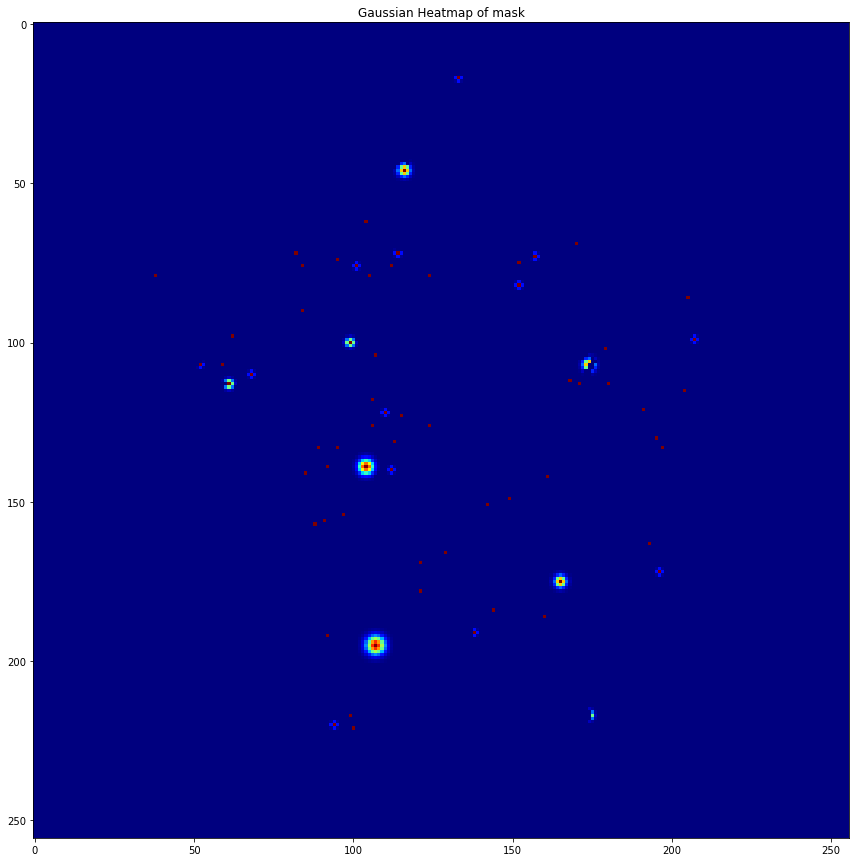

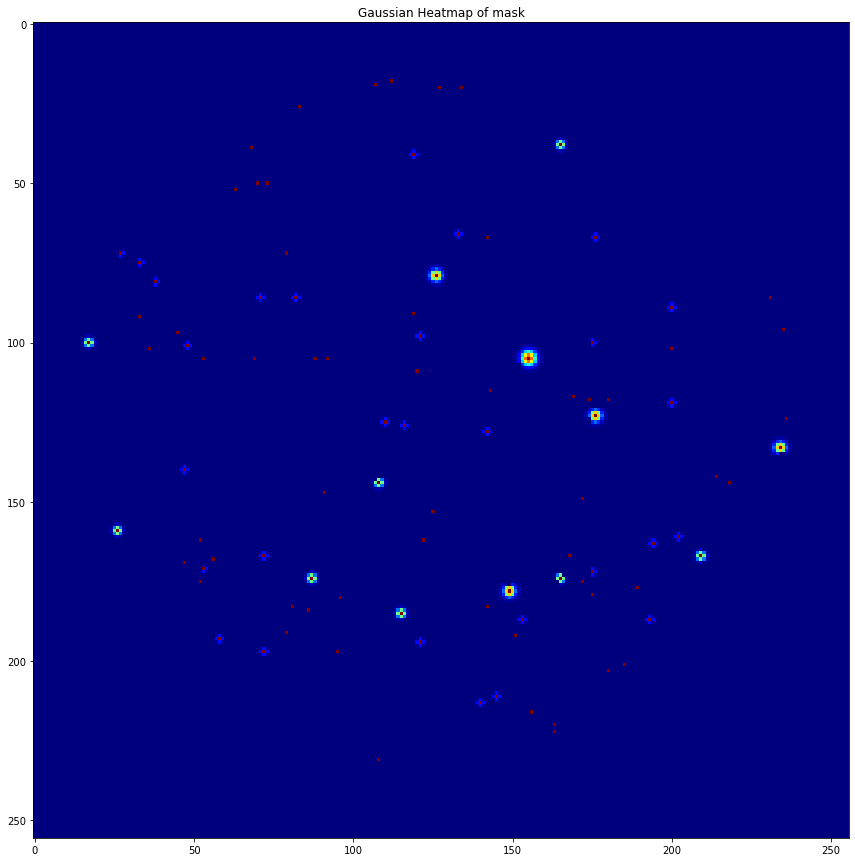

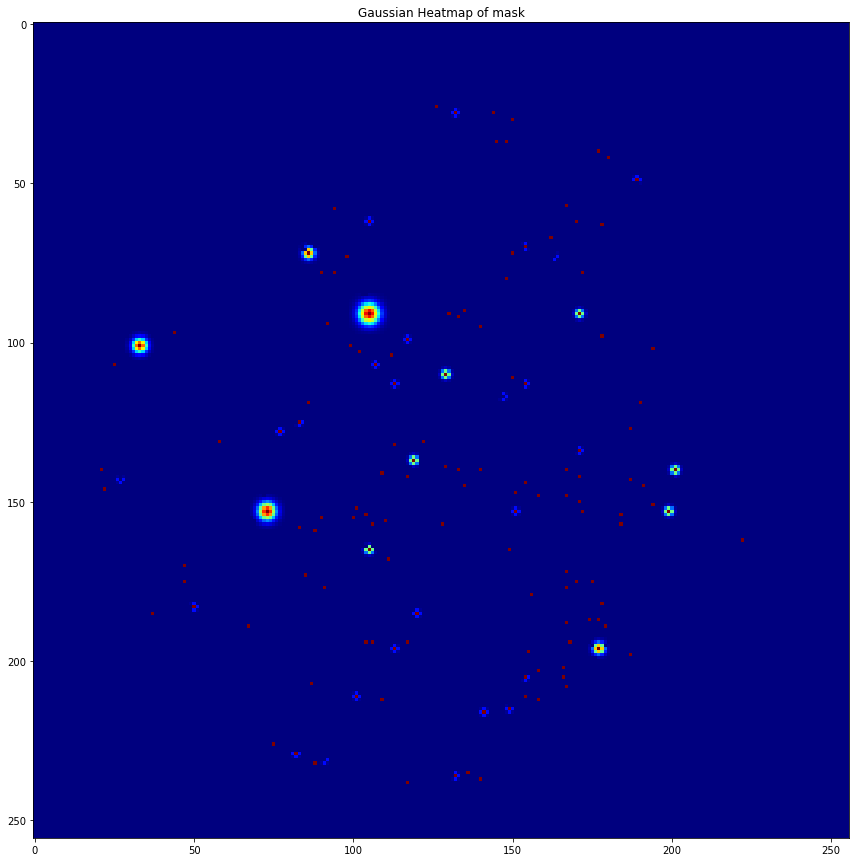

In [9]:
for mask in masks:
    
    mask_path = os.path.join(masks_path, mask)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_gray = cv2.resize(mask_gray, (256, 256))
    _, mask_thresh = cv2.threshold(mask_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    gt_map = make_gaussian_spread(mask_thresh)
    
    #Multiply by 255
#     gt_map *= 255.0
#     cv2.imwrite(os.path.join(write_path, mask), gt_map)
    
    
    plt.figure(figsize=(15,15))
    plt.title("Gaussian Heatmap of mask")
    plt.imshow(gt_map, cmap = 'jet')
#     print(gt_map.shape, gt_map.dtype)
#     print(type(gt_map))